<a href="https://colab.research.google.com/github/opherdonchin/BSF_NSF2022/blob/main/identify_processes_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_directory = '/content/drive/MyDrive/Science/BSF Grant - 2022/Data/Simulations'

Mounted at /content/drive


In [ ]:
import numpy as np
import math
import random
import pandas as pd
import pymc as pm
import arviz as az
import xarray as xr
import os
import pickle

# The identification engine (part 1)

We will first test the identification engine on data built directly from the indentification model rather than using it on data simulated from a learning experiment.

## The model

This is supposed to be the identification engine that will take measures of adaptation and skill and attempt to assess how many processes are actually involved. 

The governing equation from the grant is 

$$
y_{s,m} = \beta_{0,m} + \sum_{p=1}^{P}{x_{s,p}\beta_{p,m}} + \varepsilon_{s,m}
$$

Where the symbols mean:
- $s$ : subject index
- $m$ : measure index
- $p$ : hidden process index
- $y_{s,m}$ : actual data for subject $s$ in measure $m$
- $\beta_{0,m}$ : mean of measure $m$ across subjects
- $x_{s,p}$ : state of process $p$ for subject $s$
- $\beta_{p,m}$ : influence of proccess $p$ on measure $m$
- $\varepsilon_{s,m}$ : noise for individual subject $s$ in measure $m$

Of course, for starters we will assume that the noise in measurements is normal (although a $t$ distribution would probably work better), although perhaps some subjects are noisier than others. I'll also assume for now that the measures are normalized from 0 to 1 so that we don't have different variances for each:

$$
\varepsilon_{s,m} \sim \mathcal{N}(0, \sigma_s)
$$

In addition, each subject belongs to an experimental group $g(s)$ and we assume that the subjects in that group have similar engagements in each of the different processes:

$$
x_{s,p} \sim \mathcal{N}(\mu_{g(s), p}, \sigma_p)
$$

The full model inclues a modulation of the effects of a process ($\beta_{p,m}$) by reward, but we'll leave that out for now.


In [ ]:
# Let's just assume all of our subjects have the same noise for now
sigma_s = 0.01
# Similarly, the processes are normalized so that they have the same noise
sigma_p = 0.02


## Simulating data from the model

### Measures and processes

In this initial simulation there will be 2 processes: 

- $sr$ : strategic re-aiming
- $rc$ : recalibration

And there will be 6 measures, three adaptation measures and three measures of skill:

- Measures of adaptation
  - $lr$ : learning rate
  - $la$ : learning asymptote
  - $af$ : aftereffect
- Measures of skill: change in the measure across time, actually
  - $pr$ : preparation time required
  - $gn$ : generalization width
  - $fb$ : extent of feedback response

In [ ]:
num_processes = 2
sr = 0
rc = 1
num_measures = 6
lr = 0
la = 1
af = 2
pr = 3
gn = 4
fb = 5

measure_names = ['lr', 'la', 'af', 'pr', 'gn', 'fb']

In [ ]:
#              beta_0   sr     rc
beta_vals = [ (0.5,     0.9,   0.1) , # Learning rate
              (0.5,     0.3,   0.7) , # Learning asymptote
              (0.5,     0.0,   1.0) , # Aftereffect
              (0.5,     1.0,   0.0) , # Preparation time improvement
              (0.5,     0.2,   0.8) , # Generalization widening
              (0.5,     0.0,   1.0) , # Feedback response improving
              ]
# Create DataFrame object from a list of tuples
beta = pd.DataFrame(beta_vals, columns = ['0', 'sr', 'rc'], index=measure_names)
beta

,0,sr,rc
lr,0.5,0.9,0.1
la,0.5,0.3,0.7
af,0.5,0.0,1.0
pr,0.5,1.0,0.0
gn,0.5,0.2,0.8
fb,0.5,0.0,1.0


### Groups

The grant describes 10 groups:
- Experiment 1 ($N=60$ pre group)
  - Low-PT : low preparation time, reduced $sr$
  - High-PT : no special effect
- Experiment 2 ($N = 60$ per group)
  - Immediate : immediate feedback after movement, no special effect
  - Delay : Delay in feedback, reduced $rc$
- Experiment 3 ($N=30$ per group)
  - NoStrat25, NoStrat75 : Same as Low-PT group of experiment 1
  - NoRecal25, NoRecal75 : Same as Delay group of experiment 1
  - NoBoth25, NoBoth75 : reduction in both $sr$ and $rc$


In [ ]:
# mu is the average engagement of each group in each process
#              sr     rc
group_names = ['LowPT', 'HighPT', 'Imm', 'Delay', 'NoStrat25', 'NoStrat75', 'NoRecal25', 'NoRecal75', 'NoBoth25', 'NoBoth75']
mu_vals =   [ (0.05,  0.5)  , # Low-PT
              (0.5,   0.5)  , # High-PT
              (0.5,   0.5)  , # Immediate
              (0.5,   0.05) , # Delay
              (0.05,  0.5)  , # NoStrat25
              (0.05,  0.5)  , # NoStrat75
              (0.5,   0.05) , # NoRecal25
              (0.5,   0.05) , # NoRecal75
              (0.05,  0.05) , # NoBoth25
              (0.05,  0.05) , # NoBoth75             
             ]
mu = pd.DataFrame(mu_vals, columns = ['sr', 'rc'], index=group_names)
mu

,sr,rc
LowPT,0.05,0.50
HighPT,0.50,0.50
Imm,0.50,0.50
Delay,0.50,0.05
NoStrat25,0.05,0.50
NoStrat75,0.05,0.50
NoRecal25,0.50,0.05
NoRecal75,0.50,0.05
NoBoth25,0.05,0.05
NoBoth75,0.05,0.05


In [ ]:
group_N_vals =   [ (60)  , # Low-PT
              (60)  , # High-PT
              (60)  , # Immediate
              (60) , # Delay
              (30)  , # NoStrat25
              (30)  , # NoStrat75
              (30) , # NoRecal25
              (30) , # NoRecal75
              (30) , # NoBoth25
              (30) , # NoBoth75             
             ]
group_N = pd.DataFrame(group_N_vals, columns = ['N'], index=group_names, dtype="int")
group_N

,N
LowPT,60
HighPT,60
Imm,60
Delay,60
NoStrat25,30
NoStrat75,30
NoRecal25,30
NoRecal75,30
NoBoth25,30
NoBoth75,30


## Generate subjects

In [ ]:
groups = pd.concat((mu, group_N), axis=1)
groups

,sr,rc,N
LowPT,0.05,0.50,60
HighPT,0.50,0.50,60
Imm,0.50,0.50,60
Delay,0.50,0.05,60
NoStrat25,0.05,0.50,30
NoStrat75,0.05,0.50,30
NoRecal25,0.50,0.05,30
NoRecal75,0.50,0.05,30
NoBoth25,0.05,0.05,30
NoBoth75,0.05,0.05,30


In [ ]:
y_columns = measure_names+['group']
y = pd.DataFrame(columns=y_columns)
for gp in groups.itertuples():
  sr = random.normalvariate(gp.sr, sigma_p)
  rc = random.normalvariate(gp.rc, sigma_p)

  this_x =pd.DataFrame({"0": [1]*gp.N, "sr": sr, "rc": rc})
  these_measures = np.random.normal(loc=this_x.dot( beta.T ), scale=sigma_s)
  these_measures = pd.DataFrame(these_measures, columns=measure_names)
  these_measures['group'] = gp.Index
  y = pd.concat([y,these_measures], ignore_index=True)

from pandas.api.types import CategoricalDtype
y['group'] = y['group'].astype(CategoricalDtype(categories=group_names))

print(y)

           lr        la        af        pr        gn        fb     group
0    0.605641  0.873773  1.016019  0.569937  0.903144  1.010169     LowPT
1    0.611339  0.885949  1.006664  0.585318  0.918223  0.997473     LowPT
2    0.630398  0.873717  1.025294  0.564826  0.920328  0.977139     LowPT
3    0.613175  0.891998  1.002088  0.566276  0.924661  1.022874     LowPT
4    0.600158  0.875737  1.008605  0.562907  0.885311  1.033146     LowPT
..        ...       ...       ...       ...       ...       ...       ...
415  0.557392  0.565421  0.581109  0.542793  0.584379  0.568402  NoBoth75
416  0.552741  0.571142  0.582979  0.541075  0.575942  0.567445  NoBoth75
417  0.556334  0.562875  0.585627  0.559022  0.592586  0.590445  NoBoth75
418  0.574495  0.595750  0.600054  0.562739  0.583116  0.575080  NoBoth75
419  0.537522  0.566417  0.574977  0.560970  0.564747  0.581327  NoBoth75

[420 rows x 7 columns]


## Build PyMC model

### Reparameterization of gamma distribution

I never remember the formula for parameter transformation for the Gamma distribution. To match the PyMC documentation, we use $\alpha$ for the shape parameter and $\beta$ for the rate parameter.

If $\alpha \ge 1$:
$$
m = \frac{\alpha - 1}{\beta} \\
v = \frac{\alpha}{\beta^2}
$$
So:
$$
\alpha = v \beta^2 \\
m = \frac{v \beta^2 - 1}{\beta} \\
m \beta = v\beta^2 - 1 \\
0 = v \beta^2 - m \beta -1 \\
\beta = \frac{m + \sqrt{m^2 + 4 v}}{2v}
$$
And
$$
\alpha = 1+m\beta
$$
Note that this means there is a Gamma distribution regardless of your choice of mode and variance (as long as both are positive or 0).


In [ ]:
def gamma_mv2sr(m, v):
  r = (m + np.sqrt(m*m + 4*v)) / (2*v)
  s = 1 + m*r
  return (s, r)

def gamma_sr2mv(s,r):
  if s>1:
    m = (s-1) / r
  else:
    m = 0
  v = s / r^2
  return (m,v)


### Prior parameters

In [ ]:
sigma_p_mode = 0.5
sigma_p_s = 0.5
sigma_y_mode = 0.5
sigma_y_s = 0.5
beta_0_mu = 0.5
beta_0_s = 1
beta_mu = 0
beta_s = 1.5
mu_g_mu = 0.5
mu_g_s = 1.0

### Define model

In [ ]:
print(y.shape)
print(y.mean(axis=0))
print(y.std(axis=0))

(420, 7)
lr    0.814070
la    0.807428
af    0.804132
pr    0.815686
gn    0.806176
fb    0.803902
dtype: float64
lr    0.198647
la    0.152713
af    0.218251
pr    0.225608
gn    0.169770
fb    0.218567
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def latent_variable_model(y,groups,P):
  gp_idx = groups.cat.codes
  group_list = groups.cat.categories
  s_idx, subject_list = pd.factorize(y.index)
  m_idx, measure_list = pd.factorize(y.columns)

  sigma_p_shape, sigma_p_rate = gamma_mv2sr(sigma_p_mode, sigma_p_s*sigma_p_s)
  sigma_y_shape, sigma_y_rate = gamma_mv2sr(sigma_y_mode, sigma_y_s*sigma_y_s)

  coords = {'subject': subject_list, 'measure': measure_list, 'group':group_list, 'process': range(P)}
  with pm.Model(coords=coords) as model:
    # Priors
    sigma_p = pm.Gamma("sigma_p", alpha=sigma_p_shape, beta=sigma_p_rate)
    sigma_y = pm.Gamma("sigma_y", alpha=sigma_y_shape, beta=sigma_y_rate)
    beta = pm.Normal('beta', mu=beta_mu, sigma=sigma_p, transform=pm.distributions.transforms.simplex, dims=['process', 'measure'])
    mu_g = pm.Normal('mu_g', mu=mu_g_mu, sigma=mu_g_s, dims=['group', 'process'])
    # Latent variables
    # x = pm.Normal('x', mu=mu_g[gp_idx,:], sigma=sigma_p, dims=['subject', 'process'])
    x = pm.Deterministic('x', mu_g[gp_idx,:], dims=['subject', 'process'])
    mu_y = pm.Deterministic('mu_y', pm.math.dot(x,beta), dims=['subject', 'measure'])

    # Likelihood 
    obs_y = pm.Normal('obs_y', mu=mu_y, sigma=sigma_y, observed=y, dims=['subject', 'measure'])
  return model

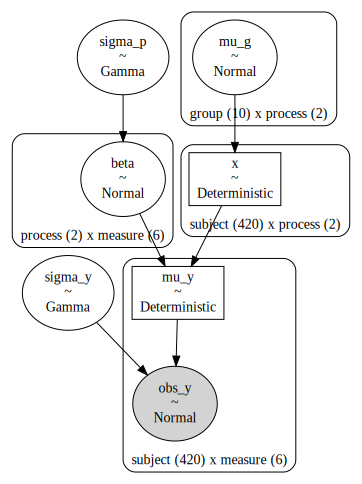

In [ ]:
model_processes = 2
model = latent_variable_model(y.drop('group',axis=1), y['group'], model_processes)
pm.model_to_graphviz(model)

In [ ]:
fit_filename = os.path.join(data_directory, f'model_samples_{model_processes}_process_new.pickle')

# os.remove(fit_filename)
if not os.path.isfile(fit_filename):
  with model:
    fit = pm.sample()

  with open(fit_filename, 'wb') as handle:
    pickle.dump(fit, handle, protocol=pickle.HIGHEST_PROTOCOL)
  # ds_fit = az.convert_to_dataset(fit)
  # ds_fit.to_netcdf(fit_filename, engine="scipy")
else:
  with open(fit_filename, 'rb') as handle:
    fit = pickle.load(handle)  
  # ds_fit = xr.open_dataset(fit_filename)
  # fit = az.convert_to_inference_data(ds_fit)

ValueError: ignored

In [ ]:
fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
with model:
  prior_samples = pm.sample_prior_predictive()

In [ ]:
post = fit.posterior
obs = fit.observed_data
post['y_err'] = obs.obs_y - post.mu_y

az.summary(fit, ['beta_0', 'beta', 'mu_g', 'sigma_y'])



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0[lr],0.864,0.091,0.766,0.966,0.064,0.054,2.0,11.0,2.38
beta_0[la],0.900,0.081,0.814,0.988,0.057,0.048,2.0,11.0,2.87
beta_0[af],0.919,0.076,0.838,1.001,0.053,0.045,2.0,11.0,2.93
beta_0[pr],0.858,0.093,0.757,0.962,0.066,0.055,2.0,11.0,2.36
beta_0[gn],0.906,0.079,0.823,0.992,0.055,0.047,2.0,11.0,2.93
beta_0[fb],0.918,0.075,0.838,1.000,0.053,0.045,2.0,11.0,2.93
"beta[0, lr]",0.186,0.025,0.155,0.216,0.017,0.015,2.0,12.0,2.49
"beta[0, la]",-0.014,0.171,-0.188,0.166,0.120,0.102,2.0,11.0,2.63
"beta[0, af]",-0.113,0.269,-0.385,0.163,0.190,0.160,3.0,12.0,2.24
"beta[0, pr]",0.218,0.056,0.155,0.279,0.039,0.033,2.0,12.0,2.40
